<a href="https://colab.research.google.com/github/GGMmattos/PIC-/blob/main/PIC_Constru%C3%A7%C3%A3o_de_modelos_de_detec%C3%A7%C3%A3o_autom%C3%A1tica_de_linguagem_ofensiva_e_ou_de_%C3%B3dio_em_l%C3%ADngua_portuguesa_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importação das bibliotecas básicas

In [73]:
!pip install plotly --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [94]:
from sklearn.metrics._plot.confusion_matrix import confusion_matrix
#Importing needed libraries 

from pandas.core.window.ewm import OnlineExponentialMovingWindow
import pandas as pd #Biblioteca para carregamento de arquivo csv
import numpy as np
import seaborn as sns #Para visualização de gráficos
import matplotlib.pyplot as plt #Para visualização de gráficos
import plotly.express as px #Biblioteca para geração de gráfico dinámico
%matplotlib inline
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

#NLTK tools for text processing 

import re, nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS

#Modeling packages 

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity ='all'





# Base de dados Artigo 1 (ToLD-BR)

---



In [75]:
base_toldbr = pd.read_csv('/content/ToLD-BR.csv')

In [76]:
base_toldbr

,text,homophobia,obscene,insult,racism,misogyny,xenophobia
0,Meu nivel de amizade com isis é ela ter meu in...,0.0,0.0,2.0,0.0,0.0,0.0
1,"rt @user @user o cara adultera dados, que fora...",0.0,0.0,1.0,0.0,0.0,0.0
2,@user @user @user o cara só é simplesmente o m...,0.0,2.0,1.0,0.0,0.0,0.0
3,eu to chorando vei vsf e eu nem staneio izone ...,0.0,1.0,0.0,0.0,0.0,0.0
4,Eleitor do Bolsonaro é tão ignorante q não per...,0.0,1.0,2.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
20995,@user faz favor vai carai,0.0,0.0,0.0,0.0,0.0,0.0
20996,só queria conhecer alguém que não conhece o he...,1.0,0.0,0.0,0.0,0.0,0.0
20997,"vcs militam na hora errada em cima de memes, p...",0.0,0.0,0.0,0.0,0.0,0.0
20998,@user porra any eu tava c dor de cabeca e fui ...,0.0,0.0,0.0,0.0,0.0,0.0


**Verificando o tamanho da Base**

In [77]:
base_toldbr.shape

(21000, 7)

**Conferindo o total de textos por categorias**

In [78]:
base_toldbr['homophobia'].value_counts()

0.0    20656
1.0      168
2.0      102
3.0       74
Name: homophobia, dtype: int64

In [79]:
base_toldbr['obscene'].value_counts()

0.0    14348
1.0     4249
2.0     1791
3.0      612
Name: obscene, dtype: int64

In [80]:
base_toldbr['insult'].value_counts()

0.0    16615
1.0     2516
2.0     1352
3.0      517
Name: insult, dtype: int64

In [81]:
base_toldbr['racism'].value_counts()

0.0    20862
1.0      105
2.0       27
3.0        6
Name: racism, dtype: int64

In [82]:
base_toldbr['misogyny'].value_counts()

0.0    20537
1.0      330
2.0      104
3.0       29
Name: misogyny, dtype: int64

In [83]:
base_toldbr['xenophobia'].value_counts()

0.0    20849
1.0      109
2.0       27
3.0       15
Name: xenophobia, dtype: int64

Verificando valores nulos e tipos de dados

In [84]:
base_toldbr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21000 entries, 0 to 20999
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   text        21000 non-null  object 
 1   homophobia  21000 non-null  float64
 2   obscene     21000 non-null  float64
 3   insult      21000 non-null  float64
 4   racism      21000 non-null  float64
 5   misogyny    21000 non-null  float64
 6   xenophobia  21000 non-null  float64
dtypes: float64(6), object(1)
memory usage: 1.1+ MB


**Como verificando logo acima não há valores NULL**

In [85]:
base_toldbr.isnull().sum()

text          0
homophobia    0
obscene       0
insult        0
racism        0
misogyny      0
xenophobia    0
dtype: int64

**Donwload dos pacotes que permitirão fazer os trabalhos de PLN**

In [86]:
import nltk 
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

**Limpeza dos dados**

In [98]:
comments = [] #criação das listas que irão conter os comentários já tratados
stop_words = set(stopwords.words('portuguese')) #setando o banco de stopwords em PT-BR

for words in base_toldbr['text']:
  only_latters =re.sub("[^a-zA-Z]", " ", words) # somente letras
  tokens = nltk.word_tokenize(only_latters) # tokenize the sentence 
  lower_case = [l.lower() for l in tokens] # converter all letters to low case 
  filtered_result = list(filter(lambda l: l not in stop_words, lower_case)) # Remove stopwords from the comments
  comments.append(' '.join(filtered_result))


<Figure size 1440x864 with 0 Axes>

(-0.5, 1999.5, 999.5, -0.5)

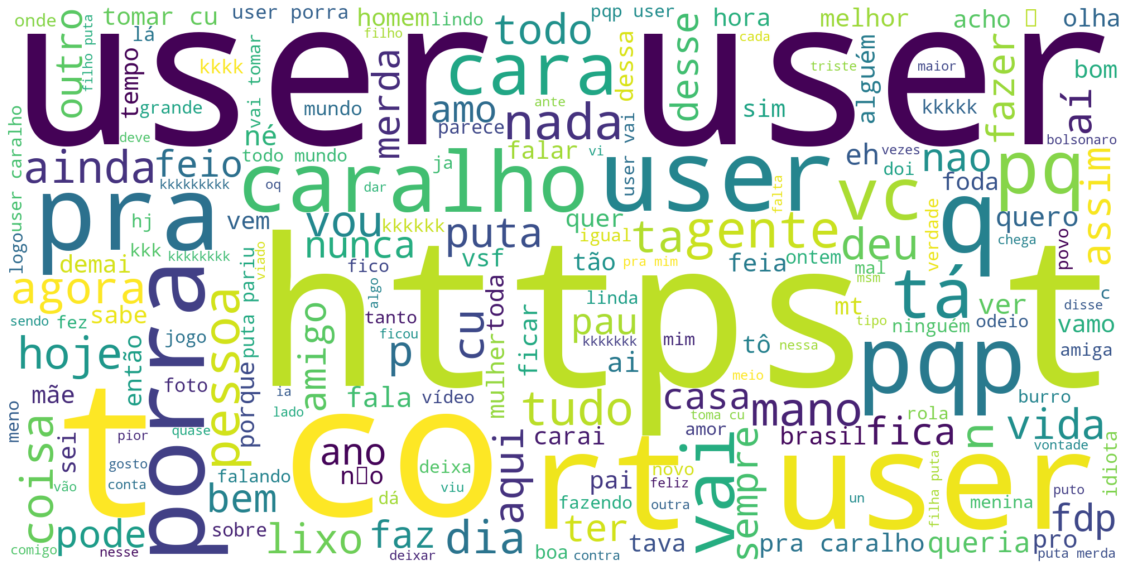

In [97]:
#Using wordclound to visualize the comments

unique_string = (" ").join(comments)
wordcloud = WordCloud(width = 2000, height = 1000, background_color='white').generate(unique_string)
plt.figure(figsize=(20,12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()




# Base de dados Artigo 2 (HateBR)

In [ ]:
base_hatebr = pd.read_csv('/content/HateBR.csv')

In [ ]:
base_hatebr

In [ ]:
np.unique(base_hatebr['offensive_language'], return_counts= True)

In [ ]:
np.unique(base_hatebr['offensiveness_levels'], return_counts= True)

In [ ]:
np.unique(base_hatebr['hate_speech'], return_counts= True)

# Base de dados Artigo 3 (OffComBR2 e OffComBR3)

In [ ]:
base_offcombr2 = pd.read_csv('/content/OffComBR2.csv')

In [ ]:
base_offcombr2

In [ ]:
np.unique(base_offcombr2['Class'], return_counts= True)

In [ ]:
base_offcombr3 = pd.read_csv('/content/OffComBR3.csv')

In [ ]:
base_offcombr3

In [ ]:
np.unique(base_offcombr3['Class'], return_counts= True)

# Base de dados Artigo 4 (base_hate_speech_binary e hate_speech_hierarchical)

In [ ]:
base_hate_speech_binary = pd.read_csv('/content/2019-05-28_portuguese_hate_speech_binary_classification.csv')

In [ ]:
base_hate_speech_binary

In [ ]:
hate_speech_hierarchical = pd.read_csv('/content/2019-05-28_portuguese_hate_speech_hierarchical_classification.csv')

In [ ]:
hate_speech_hierarchical